In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt

import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf

In [3]:
# Load your data
df = pd.read_csv('./data/tilos_hourly.csv')

# Ensure datetime column is in datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Set the datetime column as the index
df.set_index('datetime', inplace=True)

# Handle missing values if any
df = df.fillna(method='ffill')  # Forward fill as an example


In [5]:
# Create lag features
for lag in range(1, 25):
    df[f'lag_{lag}'] = df['value'].shift(lag)

# Drop rows with NaN values (due to lagging)
df.dropna(inplace=True)

# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]


In [6]:
df

,value,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-02 00:00:00,231.73,267.73,301.33,324.30,340.17,352.40,333.97,285.77,219.50,172.00,...,270.30,239.50,223.77,210.90,214.73,220.43,221.37,222.87,231.77,250.77
2021-01-02 01:00:00,217.57,231.73,267.73,301.33,324.30,340.17,352.40,333.97,285.77,219.50,...,281.33,270.30,239.50,223.77,210.90,214.73,220.43,221.37,222.87,231.77
2021-01-02 02:00:00,206.46,217.57,231.73,267.73,301.33,324.30,340.17,352.40,333.97,285.77,...,262.27,281.33,270.30,239.50,223.77,210.90,214.73,220.43,221.37,222.87
2021-01-02 03:00:00,204.77,206.46,217.57,231.73,267.73,301.33,324.30,340.17,352.40,333.97,...,257.17,262.27,281.33,270.30,239.50,223.77,210.90,214.73,220.43,221.37
2021-01-02 04:00:00,202.37,204.77,206.46,217.57,231.73,267.73,301.33,324.30,340.17,352.40,...,187.63,257.17,262.27,281.33,270.30,239.50,223.77,210.90,214.73,220.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-25 19:00:00,456.13,420.13,395.87,343.43,321.83,336.43,316.93,316.77,307.00,324.43,...,347.33,356.50,389.43,421.37,444.13,468.00,485.13,497.30,470.83,439.10
2021-06-25 20:00:00,502.70,456.13,420.13,395.87,343.43,321.83,336.43,316.93,316.77,307.00,...,339.40,347.33,356.50,389.43,421.37,444.13,468.00,485.13,497.30,470.83
2021-06-25 21:00:00,533.20,502.70,456.13,420.13,395.87,343.43,321.83,336.43,316.93,316.77,...,235.20,339.40,347.33,356.50,389.43,421.37,444.13,468.00,485.13,497.30


In [7]:
import xgboost as xgb

# Separate features and target
X_train, y_train = train.drop('value', axis=1), train['value']
X_test, y_test = test.drop('value', axis=1), test['value']

# Convert to DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


In [13]:
X_train

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-02 00:00:00,267.73,301.33,324.30,340.17,352.40,333.97,285.77,219.50,172.00,146.03,...,270.30,239.50,223.77,210.90,214.73,220.43,221.37,222.87,231.77,250.77
2021-01-02 01:00:00,231.73,267.73,301.33,324.30,340.17,352.40,333.97,285.77,219.50,172.00,...,281.33,270.30,239.50,223.77,210.90,214.73,220.43,221.37,222.87,231.77
2021-01-02 02:00:00,217.57,231.73,267.73,301.33,324.30,340.17,352.40,333.97,285.77,219.50,...,262.27,281.33,270.30,239.50,223.77,210.90,214.73,220.43,221.37,222.87
2021-01-02 03:00:00,206.46,217.57,231.73,267.73,301.33,324.30,340.17,352.40,333.97,285.77,...,257.17,262.27,281.33,270.30,239.50,223.77,210.90,214.73,220.43,221.37
2021-01-02 04:00:00,204.77,206.46,217.57,231.73,267.73,301.33,324.30,340.17,352.40,333.97,...,187.63,257.17,262.27,281.33,270.30,239.50,223.77,210.90,214.73,220.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-21 19:00:00,264.10,237.63,231.53,205.23,101.63,117.60,115.23,114.50,197.07,183.70,...,201.93,211.83,220.63,232.77,245.80,255.27,284.80,325.57,316.70,275.00
2021-05-21 20:00:00,284.40,264.10,237.63,231.53,205.23,101.63,117.60,115.23,114.50,197.07,...,199.93,201.93,211.83,220.63,232.77,245.80,255.27,284.80,325.57,316.70
2021-05-21 21:00:00,289.67,284.40,264.10,237.63,231.53,205.23,101.63,117.60,115.23,114.50,...,198.67,199.93,201.93,211.83,220.63,232.77,245.80,255.27,284.80,325.57


In [9]:
# Define the parameters for the XGBoost model
params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Train the model
num_boost_round = 100
bst = xgb.train(params, dtrain, num_boost_round)


In [10]:
from sklearn.metrics import mean_squared_error

# Make predictions
preds = bst.predict(dtest)

# Evaluate the model
mse = mean_squared_error(y_test, preds)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 702.8792662845091


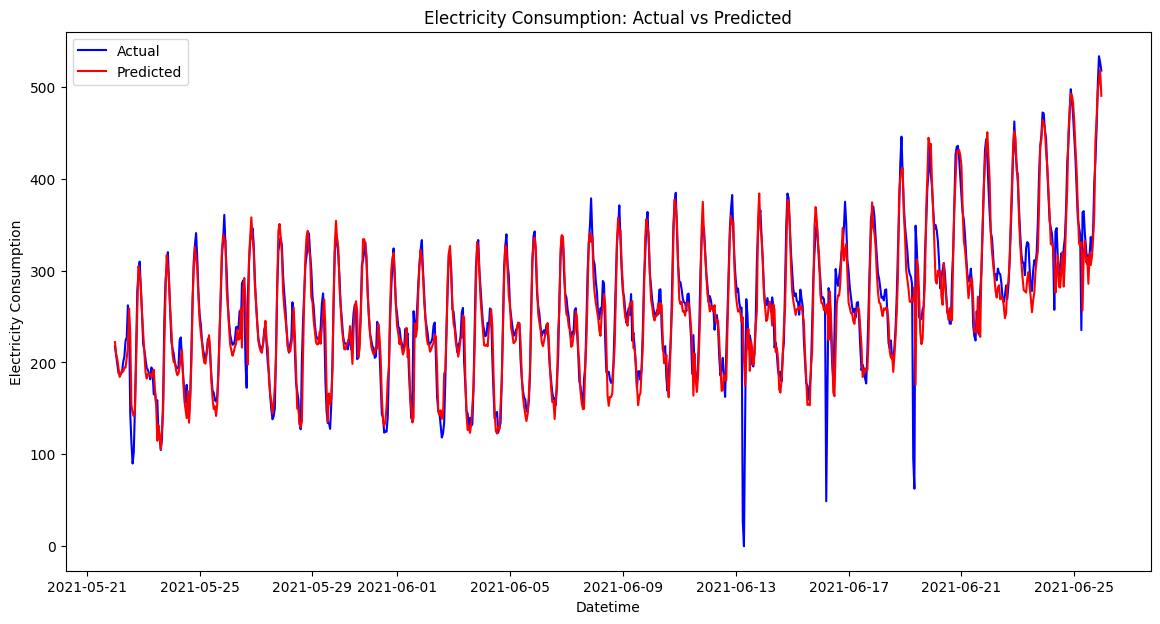

In [11]:
import matplotlib.pyplot as plt

# Assuming preds contains your predictions and y_test contains the actual values

# Create a DataFrame to hold the actual and predicted values
results = pd.DataFrame({'Actual': y_test, 'Predicted': preds}, index=y_test.index)

# Plot the results
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(results.index, results['Actual'], label='Actual', color='blue')

# Plot predicted values
plt.plot(results.index, results['Predicted'], label='Predicted', color='red')

# Add title and labels
plt.title('Electricity Consumption: Actual vs Predicted')
plt.xlabel('Datetime')
plt.ylabel('Electricity Consumption')

# Show legend
plt.legend()

# Display the plot
plt.show()


In [12]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Assuming preds contains your predictions and y_test contains the actual values

# Calculate the metrics
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, preds)

# Print the metrics (optional)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

# Create a DataFrame to hold the metrics
metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE'],
    'Value': [mse, rmse, mae]
})

# Save the DataFrame to a CSV file
metrics_df.to_csv('metricsXGB1.csv', index=False)

# Print confirmation (optional)
print('Metrics saved to metrics.csv')



Mean Squared Error (MSE): 702.8792662845091
Root Mean Squared Error (RMSE): 26.511870290202257
Mean Absolute Error (MAE): 15.979796467009045
Metrics saved to metrics.csv
